In [2]:
# Basic libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import seaborn as sn



#!pip3 install pyramid-arima
import pmdarima as pm

#Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse

from pmdarima import auto_arima

# SCIPY
from scipy.stats import boxcox

# SKLearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Iteration
from itertools import product
from tqdm import tqdm_notebook

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#Figure Sizes and Label font-sizes
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linewidth":0.8, "grid.alpha": 0.5})

In [3]:
# Load Data
data = pd.read_csv('data.csv')  # Ensure filename matches

data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']  # Ensure proper column names
data = data[['Year', 'Smooth_5yr']]
data.set_index('Year', inplace=True)
df = data
df.head()

,Smooth_5yr
Year,
1901,27.23
1902,27.21
1903,27.18
1904,27.15
1905,27.12


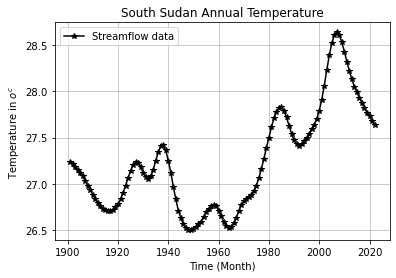

In [4]:
plt.rcParams.update({'figure.figsize': [20,10]})
plt.rcParams.update({'font.size': 14})
plt.plot(df.index, df['Smooth_5yr'], 'b*-', label='Streamflow data', c='black', alpha=1)
plt.title('South Sudan Annual Temperature')
plt.xlabel('Time (Month)')
plt.ylabel('Temperature in $o^{c}$')
plt.grid(True)
plt.legend()
# plt.savefig('revisedImages/sobat_streamflow_volume_1915_144.png')
plt.show()

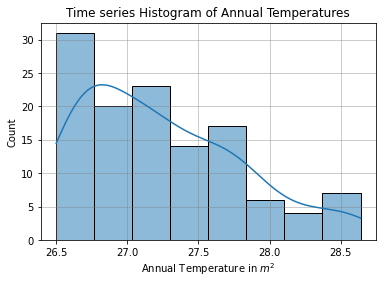

In [5]:
sns.histplot(df['Smooth_5yr'], kde=True)
plt.title('Time series Histogram of Annual Temperatures')
plt.xlabel('Annual Temperature in $m^{2}$')
plt.grid(True)
# plt.savefig('revisedImages/sobat_histogram_of_streamflow.png')
plt.show()

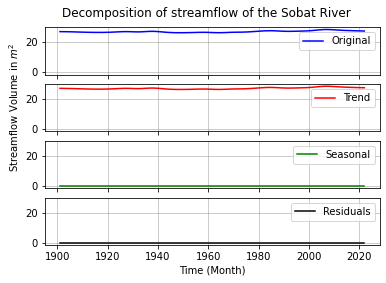

In [6]:
ts_decompose_add = seasonal_decompose(df['Smooth_5yr'], model='additive', period=1,)  # Adjust period as needed
estimated_trend_add = ts_decompose_add.trend
estimated_seasonal_add = ts_decompose_add.seasonal
estimated_residual_add = ts_decompose_add.resid

fig, axes = plt.subplots(4, 1, sharex="all", sharey=True)
plt.rcParams.update({'figure.figsize': [14,5]})
plt.suptitle('Decomposition of streamflow of the Sobat River',x=0.5, y=0.95)
plt.xlabel('Time (Month)')



axes[0].plot(df['Smooth_5yr'], label='Original', color='b')
axes[0].legend(loc='upper right');

axes[1].plot(estimated_trend_add, label='Trend', color='r')
axes[1].legend(loc='upper right');

axes[2].plot(estimated_seasonal_add, label='Seasonal', color='g')
axes[1].set_ylabel('Streamflow Volume in $m^{2}$')
axes[2].legend(loc='upper right');

axes[3].plot(estimated_residual_add, label='Residuals', color='black')
axes[3].legend(loc='upper right');
# plt.savefig('revisedImages/sobat_decompositions_of_streamflow.png')

In [7]:
ad_fuller_result = adfuller(df['Smooth_5yr'])
print(f'Test Statistics: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Lags used: {ad_fuller_result[2]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (ad_fuller_result[1] < 0.05):
    print('The Null Hypothesis is rejected in favor of the alternate Hypothesis. The series is stationary and requires no differencing')
if (ad_fuller_result[1] > 0.05):        
    print('The Null Hypothesis is not rejected. The series has a unit root, hence non-stationary and requires differencing')

kpss_result = kpss(df['Smooth_5yr'])
print(f'Test Statistics: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Number of Lags used: {kpss_result[2]}')
for key, value in kpss_result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (kpss_result[1] > 0.05):
    print('The Null Hypothesis is not rejected: The time series is trend stationary (series is stationary)')
if (kpss_result[1] < 0.05):        
    print('The Null Hypothesis is rejected: The time series has a unit root (series is not stationary)')

Test Statistics: -1.245082814901279
p-value: 0.6539079841743723
Lags used: 13
Critial Values:
   1%, -3.4924012594942333
Critial Values:
   5%, -2.8886968193364835
Critial Values:
   10%, -2.5812552709190673
The Null Hypothesis is not rejected. The series has a unit root, hence non-stationary and requires differencing
Test Statistics: 1.0220697052397718
p-value: 0.01
Number of Lags used: 6
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
The Null Hypothesis is rejected: The time series has a unit root (series is not stationary)


In [8]:
# Apply differencing if needed
difference_data = df
difference_data['Smooth_5yr'] = difference_data['Smooth_5yr'].diff().dropna()
print("Differencing was applied to make the series stationary.")
difference_data.head()

Differencing was applied to make the series stationary.


,Smooth_5yr
Year,
1901,NaN
1902,-0.02
1903,-0.03
1904,-0.03
1905,-0.03


In [9]:
dt = difference_data.dropna()
ad_fuller_result = adfuller(dt['Smooth_5yr'])
print(f'Test Statistics: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'Lags used: {ad_fuller_result[2]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (ad_fuller_result[1] < 0.05):
    print('The Null Hypothesis is rejected in favor of the alternate Hypothesis. The series is stationary and requires no differencing')
if (ad_fuller_result[1] > 0.05):        
    print('The Null Hypothesis is not rejected. The series has a unit root, hence non-stationary and requires differencing')

kpss_result = kpss(dt['Smooth_5yr'])
print(f'Test Statistics: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Number of Lags used: {kpss_result[2]}')
for key, value in kpss_result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 
if (kpss_result[1] > 0.05):
    print('The Null Hypothesis is not rejected: The time series is trend stationary (series is stationary)')
if (kpss_result[1] < 0.05):        
    print('The Null Hypothesis is rejected: The time series has a unit root (series is not stationary)')

Test Statistics: -2.9490042753980177
p-value: 0.0399390524355897
Lags used: 13
Critial Values:
   1%, -3.492995948509562
Critial Values:
   5%, -2.888954648057252
Critial Values:
   10%, -2.58139291903223
The Null Hypothesis is rejected in favor of the alternate Hypothesis. The series is stationary and requires no differencing
Test Statistics: 0.10300346238906818
p-value: 0.1
Number of Lags used: 6
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
The Null Hypothesis is not rejected: The time series is trend stationary (series is stationary)


In [10]:
# Train-Test Split
data = pd.read_csv('data.csv')  # Ensure filename matches

data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']  # Ensure proper column names
data = data[['Year', 'Smooth_5yr']]
data.set_index('Year', inplace=True)

split_index = int(len(data) * 0.95)
train, test = data.iloc[:split_index], df.iloc[split_index:]
test.head()

,Smooth_5yr
Year,
2016,-0.06
2017,-0.06
2018,-0.05
2019,-0.05
2020,-0.04


In [11]:
# SARIMA Model using AutoARIMA
auto_arima_model_sarima = auto_arima(train.dropna(), seasonal=True, m=1, d=1, D=0, trace=True, suppress_warnings=True)
best_order_sarima = auto_arima_model_sarima.order
best_seasonal_order_sarima = auto_arima_model_sarima.seasonal_order

sarima_model = SARIMAX(train.dropna(), order=best_order_sarima, seasonal_order=best_seasonal_order_sarima)
sarima_fit = sarima_model.fit()
sarima_pred = sarima_fit.forecast(steps=len(test))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-678.324, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-281.868, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-522.233, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-408.631, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-282.811, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-630.561, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-666.460, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-700.731, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-670.344, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-659.226, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-698.050, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-689.922, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-675.181, Time=0.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-663.294, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0]          

In [12]:
# ARIMA Model using AutoARIMA
auto_arima_model = auto_arima(train.dropna(), seasonal=False, m=1, d=2, D=0, trace=True, suppress_warnings=True)
best_order = auto_arima_model.order

arima_model = ARIMA(train.dropna(), order=best_order)
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-690.406, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-517.717, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-628.446, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-580.423, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-519.692, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-642.051, Time=0.30 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-624.460, Time=0.29 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-688.042, Time=0.35 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-688.519, Time=0.42 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-628.965, Time=0.16 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-653.708, Time=0.30 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-666.957, Time=0.33 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-686.411, Time=0.44 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-692.380, Time=0.28 sec
 ARIMA(1,2,2)(0,0,0)[0]          

In [13]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Smooth_5yr   No. Observations:                  115
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 351.190
Date:                Wed, 05 Mar 2025   AIC                           -692.380
Time:                        02:41:25   BIC                           -678.744
Sample:                             0   HQIC                          -686.847
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5335      0.053     28.918      0.000       1.430       1.637
ar.L2         -0.8325      0.047    -17.845      0.000      -0.924      -0.741
ma.L1         -0.9829      0.043    -22.959      0.000      -1.067      -0.899
ma.L2          0.9039      0.054     16.700      0.000       0.798       1.010
sigma2         0.0001   1.79e-05      6.244      0.000    7.66e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.66   Prob(JB):                         0.42
Heteroskedasticity (H):               1.29   Skew:                            -0.15
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

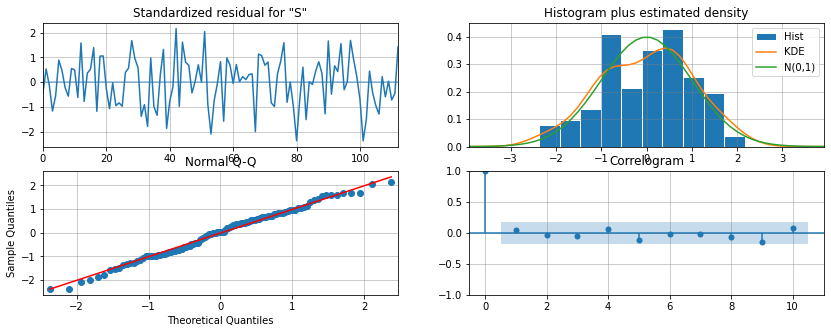

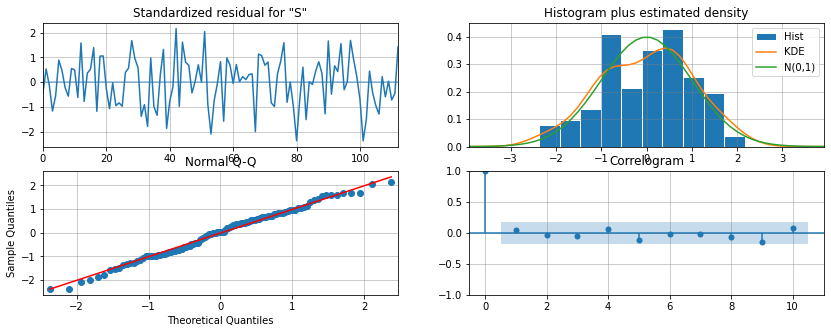

In [14]:
arima_fit.plot_diagnostics()

In [15]:
# Evaluation
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}')

evaluate(test['Smooth_5yr'].iloc[-len(arima_pred):], arima_pred, 'ARIMA')
evaluate(test['Smooth_5yr'].iloc[-len(sarima_pred):], sarima_pred, 'SARIMA')

ARIMA -> MAE: 27.8134, RMSE: 27.8136, R²: -13537978.2269
SARIMA -> MAE: 27.8814, RMSE: 27.8815, R²: -13604088.6566


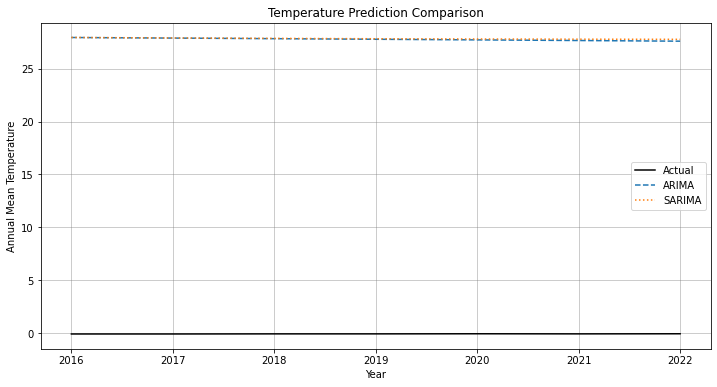

In [16]:
# Plot Results
plt.figure(figsize=(12,6))
plt.plot(test.index, test['Smooth_5yr'], label='Actual', color='black')
plt.plot(test.index[-len(arima_pred):], arima_pred, label='ARIMA', linestyle='dashed')
plt.plot(test.index[-len(sarima_pred):], sarima_pred, label='SARIMA', linestyle='dotted')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Annual Mean Temperature')
plt.title('Temperature Prediction Comparison')
plt.show()

In [1]:
2+2


4

2025-03-05 03:39:13,071 - INFO - Loading data from data.csv
2025-03-05 03:39:13,077 - INFO - Data loaded: 122 rows, range 1901 to 2022
2025-03-05 03:39:13,079 - INFO - Creating enhanced temperature column
2025-03-05 03:39:13,088 - INFO - Outliers removed: 0
2025-03-05 03:39:13,091 - INFO - Adding features
2025-03-05 03:39:13,106 - INFO - Train period: 1990 to 2015 (26 years)
2025-03-05 03:39:13,108 - INFO - Test period: 2016 to 2022 (7 years)
2025-03-05 03:39:13,109 - INFO - Fitting Random Forest
2025-03-05 03:39:24,703 - INFO - Best RF params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
2025-03-05 03:39:24,821 - INFO - Fitting XGBoost
2025-03-05 03:39:29,009 - INFO - Best XGBoost params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
2025-03-05 03:39:29,160 - INFO - Fitting Gradient Boosting
2025-03-05 03:39:33,171 - INFO - Best GBM params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
2025-03-05 03:39:33,283 - INFO - Fitting ARIMA
2025-

Random Forest - RMSE: 0.2321, R²: -1.9807, MAE: 0.2119
XGBoost - RMSE: 0.2285, R²: -1.8890, MAE: 0.2042
Gradient Boosting - RMSE: 0.2168, R²: -1.5997, MAE: 0.1963
ARIMA - RMSE: 0.2397, R²: -2.1780, MAE: 0.2140
Holt-Winters - RMSE: 0.2397, R²: -2.1780, MAE: 0.2140
SARIMA - RMSE: 0.2397, R²: -2.1780, MAE: 0.2140
Linear Regression - RMSE: 0.6654, R²: -23.4995, MAE: 0.6340


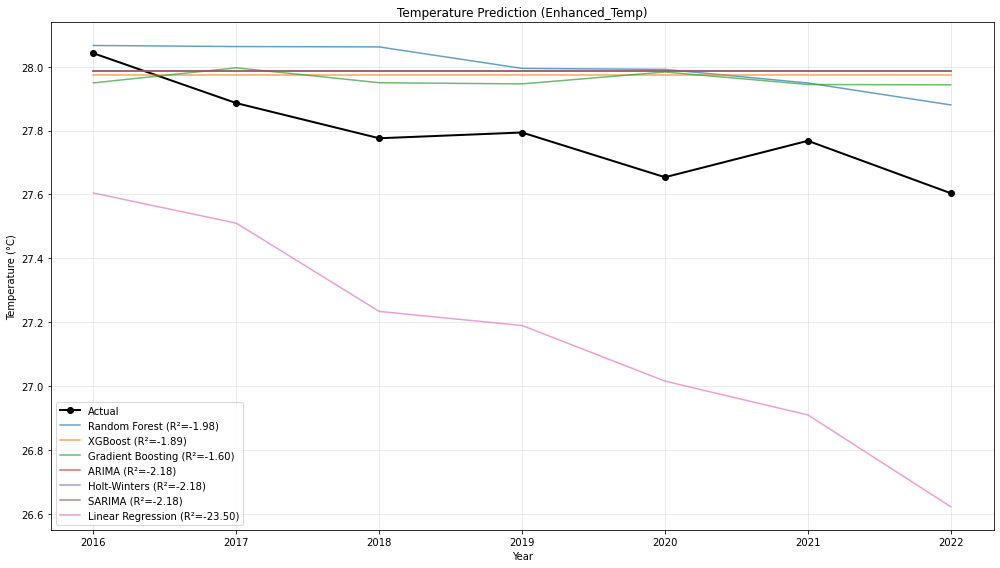

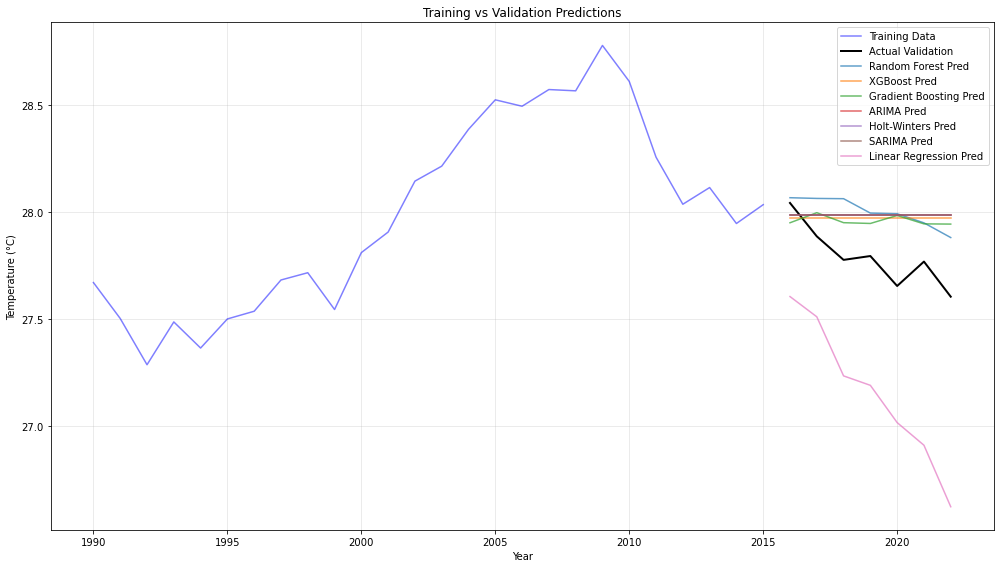


Model Performance Summary:
Random Forest: RMSE=0.2321, R²=-1.9807, MAE=0.2119
XGBoost: RMSE=0.2285, R²=-1.8890, MAE=0.2042
Gradient Boosting: RMSE=0.2168, R²=-1.5997, MAE=0.1963
ARIMA: RMSE=0.2397, R²=-2.1780, MAE=0.2140
Holt-Winters: RMSE=0.2397, R²=-2.1780, MAE=0.2140
SARIMA: RMSE=0.2397, R²=-2.1780, MAE=0.2140
Linear Regression: RMSE=0.6654, R²=-23.4995, MAE=0.6340


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import median_abs_deviation
import logging
import gc
import warnings

warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load Data
try:
    logger.info("Loading data from data.csv")
    data = pd.read_csv('data.csv')
    data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']
    data = data.set_index('Year')
    logger.info(f"Data loaded: {len(data)} rows, range {data.index.min()} to {data.index.max()}")
except FileNotFoundError:
    logger.error("data.csv not found.")
    raise
except Exception as e:
    logger.error(f"Error loading data: {e}")
    raise

# Enhanced column creation with outlier reduction
def create_enhanced_column(df, raw_col='Annual_Mean', smooth_col='Smooth_5yr', mad_threshold=5):
    logger.info("Creating enhanced temperature column")
    combined = 0.4 * df[raw_col] + 0.6 * df[smooth_col]
    if combined.isnull().any():
        logger.warning("NaNs in combined data, filling with column means.")
        combined = combined.fillna(combined.mean())
    median = combined.median()
    mad = median_abs_deviation(combined.dropna(), scale='normal')
    if mad == 0:
        logger.warning("MAD is zero, using combined data without outlier correction.")
        return combined
    z_scores = (combined - median) / mad
    outliers = np.abs(z_scores) > mad_threshold
    enhanced = combined.copy()
    enhanced[outliers] = np.nan
    enhanced = enhanced.interpolate(method='linear')
    if enhanced.isnull().any():
        logger.warning("NaNs after interpolation, filling with median.")
        enhanced = enhanced.fillna(median)
    logger.info(f"Outliers removed: {outliers.sum()}")
    return enhanced

# Add enhanced column
data['Enhanced_Temp'] = create_enhanced_column(data)
df = data[['Enhanced_Temp']].copy()
df['Year'] = df.index

# Feature Engineering
def add_features(df, target_col='Enhanced_Temp', lags=3, window=5):
    logger.info("Adding features")
    for lag in range(1, lags + 1):
        df[f'Lag{lag}'] = df[target_col].shift(lag)
    df['Rolling_Mean'] = df[target_col].rolling(window=window, min_periods=1).mean()
    df['Rolling_Std'] = df[target_col].rolling(window=window, min_periods=1).std()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df[['Year']])
    df[['Year', 'Year^2']] = poly_features
    df['Decade'] = (df.index // 10) * 10
    df = df.dropna()
    if df.isnull().any().any():
        logger.warning("NaNs in features after dropna, filling with column means.")
        df = df.fillna(df.mean())
    return df

df = add_features(df)

# Train-Test Split
train_start, train_end = 1990, 2015
val_start, val_end = 2016, 2022
train = df.loc[train_start:train_end]
test = df.loc[val_start:val_end]

X_train, X_test = train.drop(columns=['Enhanced_Temp']), test.drop(columns=['Enhanced_Temp'])
y_train, y_test = train['Enhanced_Temp'], test['Enhanced_Temp']

logger.info(f"Train period: {train.index.min()} to {train.index.max()} ({len(train)} years)")
logger.info(f"Test period: {test.index.min()} to {test.index.max()} ({len(test)} years)")

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name, verbose=True):
    if len(y_true) != len(y_pred):
        logger.error(f"Length mismatch in {model_name}: y_true ({len(y_true)}) vs y_pred ({len(y_pred)})")
        raise ValueError(f"Length mismatch: y_true ({len(y_true)}) vs y_pred ({len(y_pred)})")
    if np.any(np.isnan(y_pred)):
        logger.warning(f"{model_name} predictions contain {np.isnan(y_pred).sum()} NaNs, filling with mean.")
        y_pred = pd.Series(y_pred).fillna(y_true.mean()).values  # Fallback to mean if all NaN
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    if verbose:
        print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return {'rmse': rmse, 'r2': r2, 'mae': mae}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# ----------------- Random Forest -----------------
logger.info("Fitting Random Forest")
rf_params = {'n_estimators': [100, 500], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.best_estimator_.predict(X_test)
logger.info(f"Best RF params: {rf_model.best_params_}")
gc.collect()

# ----------------- XGBoost -----------------
logger.info("Fitting XGBoost")
xgb_params = {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.05], 'max_depth': [3, 5]}
xgb_model = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.best_estimator_.predict(X_test)
logger.info(f"Best XGBoost params: {xgb_model.best_params_}")
gc.collect()

# ----------------- Gradient Boosting -----------------
logger.info("Fitting Gradient Boosting")
gbm_params = {'n_estimators': [100, 500], 'learning_rate': [0.01, 0.05], 'max_depth': [3, 5]}
gbm_model = GridSearchCV(GradientBoostingRegressor(random_state=42), gbm_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)
gbm_model.fit(X_train, y_train)
gbm_preds = gbm_model.best_estimator_.predict(X_test)
logger.info(f"Best GBM params: {gbm_model.best_params_}")
gc.collect()

# ----------------- ARIMA -----------------
logger.info("Fitting ARIMA")
best_aic, best_order = float("inf"), None
for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            try:
                model = ARIMA(y_train, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic, best_order = model.aic, (p, d, q)
            except Exception as e:
                logger.debug(f"ARIMA order {(p, d, q)} failed: {e}")
                continue
arima_model = ARIMA(y_train, order=best_order).fit()
arima_preds = arima_model.forecast(steps=len(y_test))
arima_preds = pd.Series(arima_preds, index=y_test.index)
if arima_preds.isnull().any():
    logger.warning("ARIMA predictions contain NaNs, filling with mean.")
    arima_preds = arima_preds.fillna(y_train.mean())
logger.info(f"Best ARIMA order: {best_order}")
gc.collect()

# ----------------- Holt-Winters -----------------
logger.info("Fitting Holt-Winters")
try:
    hw_model = ExponentialSmoothing(y_train, trend='add', seasonal=None, damped_trend=True)
    hw_model = hw_model.fit(optimized=True)
    hw_preds = hw_model.forecast(steps=len(y_test))
    hw_preds = pd.Series(hw_preds, index=y_test.index)
    if hw_preds.isnull().any():
        logger.warning("Holt-Winters predictions contain NaNs, filling with mean.")
        hw_preds = hw_preds.fillna(y_train.mean())
except Exception as e:
    logger.error(f"Holt-Winters fitting failed: {e}, using mean as fallback.")
    hw_preds = pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
gc.collect()

# ----------------- SARIMA -----------------
logger.info("Fitting SARIMA")
try:
    sarima_model = sm.tsa.statespace.SARIMAX(
        y_train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False, enforce_invertibility=False
    )
    sarima_model = sarima_model.fit(disp=False)
    sarima_preds = sarima_model.forecast(steps=len(y_test))
    sarima_preds = pd.Series(sarima_preds, index=y_test.index)
    if sarima_preds.isnull().any():
        logger.warning("SARIMA predictions contain NaNs, filling with mean.")
        sarima_preds = sarima_preds.fillna(y_train.mean())
except Exception as e:
    logger.error(f"SARIMA fitting failed: {e}, using mean as fallback.")
    sarima_preds = pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
gc.collect()

# ----------------- Linear Regression -----------------
logger.info("Fitting Linear Regression")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_preds = pd.Series(lr_preds, index=y_test.index)

# ----------------- Model Evaluation -----------------
models = {
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "Gradient Boosting": gbm_preds,
    "ARIMA": arima_preds,
    "Holt-Winters": hw_preds,
    "SARIMA": sarima_preds,
    "Linear Regression": lr_preds
}

results = {}
for name, preds in models.items():
    metrics = evaluate_model(y_test, preds, name)
    results[name] = metrics

# ----------------- Plot Predictions -----------------
plt.figure(figsize=(14, 8))
plt.plot(test.index, y_test, label='Actual', marker='o', color='black', linewidth=2)
for name, preds in models.items():
    plt.plot(test.index, preds, label=f'{name} (R²={results[name]["r2"]:.2f})', alpha=0.7)
plt.legend()
plt.title('Temperature Prediction (Enhanced_Temp)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Diagnostic Plot
plt.figure(figsize=(14, 8))
plt.plot(train.index, y_train, label='Training Data', color='blue', alpha=0.5)
plt.plot(test.index, y_test, label='Actual Validation', color='black', linewidth=2)
for name, preds in models.items():
    plt.plot(test.index, preds, label=f'{name} Pred', alpha=0.7)
plt.legend()
plt.title('Training vs Validation Predictions')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print Summary
print("\nModel Performance Summary:")
for name, metrics in results.items():
    print(f"{name}: RMSE={metrics['rmse']:.4f}, R²={metrics['r2']:.4f}, MAE={metrics['mae']:.4f}")

2025-03-05 03:48:42,686 - INFO - Loading data from data.csv
2025-03-05 03:48:42,697 - INFO - Data loaded: 122 rows, range 1901 to 2022
2025-03-05 03:48:42,700 - INFO - Creating enhanced mean column
2025-03-05 03:48:42,707 - INFO - Outliers removed: 0
2025-03-05 03:48:42,713 - INFO - Adding features
2025-03-05 03:48:42,733 - INFO - Train period: 1990 to 2015 (26 years)
2025-03-05 03:48:42,734 - INFO - Test period: 2016 to 2022 (7 years)
2025-03-05 03:48:42,736 - INFO - Fitting Random Forest
2025-03-05 03:48:51,441 - INFO - Best RF params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
2025-03-05 03:48:51,651 - INFO - Fitting XGBoost
2025-03-05 03:48:54,813 - INFO - Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
2025-03-05 03:48:54,977 - INFO - Fitting Gradient Boosting
2025-03-05 03:48:57,751 - INFO - Best GBM params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
2025-03-05 03:48:57,886 - INFO - Fitting ARIMA
2025-03-05 03:

Random Forest - RMSE: 0.3061, R²: -5.9092, MAE: 0.2809
XGBoost - RMSE: 0.3221, R²: -6.6520, MAE: 0.2873
Gradient Boosting - RMSE: 0.3172, R²: -6.4222, MAE: 0.2822
ARIMA - RMSE: 0.1270, R²: -0.1897, MAE: 0.1097
Holt-Winters - RMSE: 0.1270, R²: -0.1897, MAE: 0.1097
SARIMA - RMSE: 0.1270, R²: -0.1897, MAE: 0.1097
Linear Regression - RMSE: 0.0000, R²: 1.0000, MAE: 0.0000
Stacking Ensemble - RMSE: 0.2425, R²: -3.3363, MAE: 0.2155


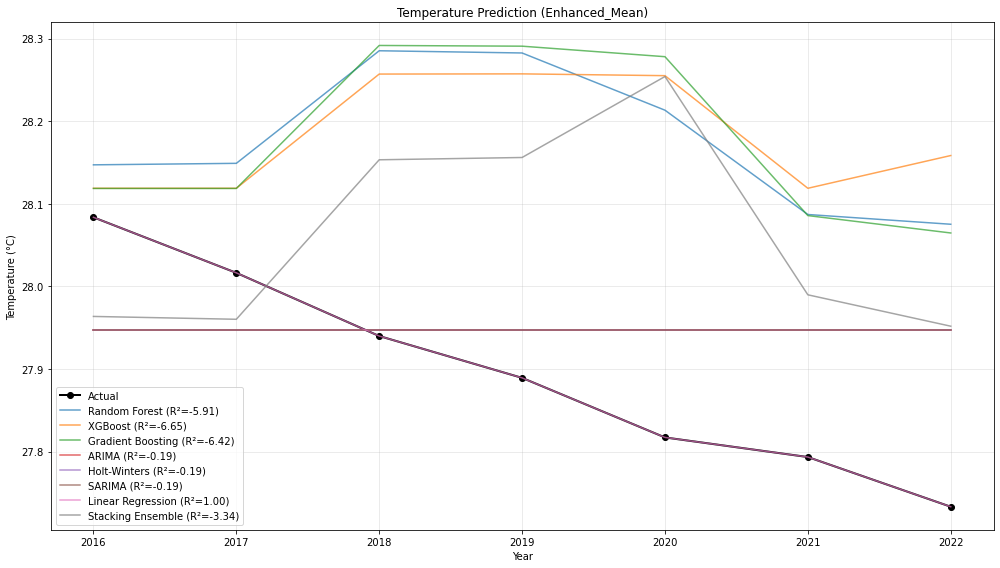

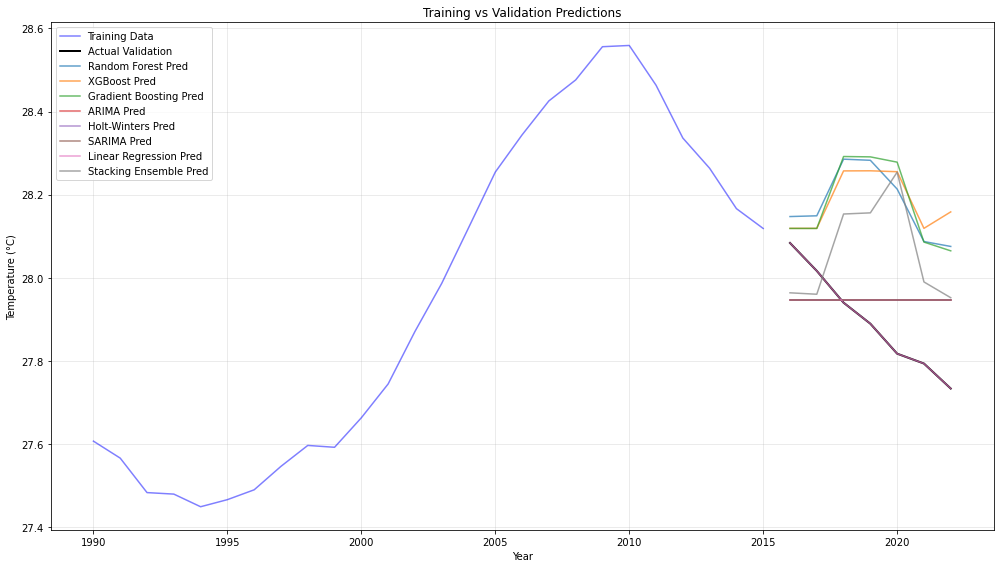

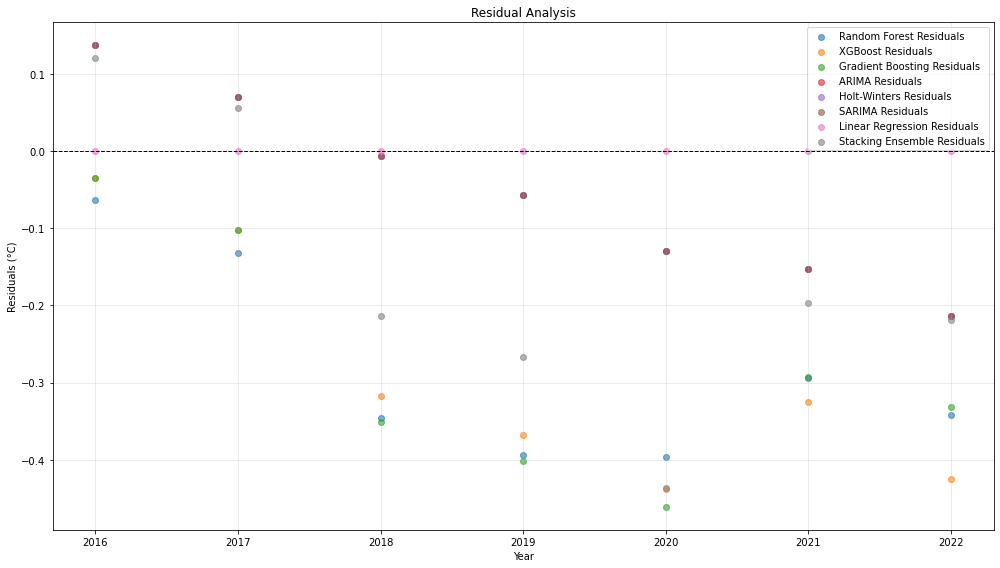


Model Performance Summary:
Random Forest: RMSE=0.3061, R²=-5.9092, MAE=0.2809
XGBoost: RMSE=0.3221, R²=-6.6520, MAE=0.2873
Gradient Boosting: RMSE=0.3172, R²=-6.4222, MAE=0.2822
ARIMA: RMSE=0.1270, R²=-0.1897, MAE=0.1097
Holt-Winters: RMSE=0.1270, R²=-0.1897, MAE=0.1097
SARIMA: RMSE=0.1270, R²=-0.1897, MAE=0.1097
Linear Regression: RMSE=0.0000, R²=1.0000, MAE=0.0000
Stacking Ensemble: RMSE=0.2425, R²=-3.3363, MAE=0.2155


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import StackingRegressor
from scipy.stats import median_abs_deviation
import logging
import gc
import warnings

warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load Data
try:
    logger.info("Loading data from data.csv")
    data = pd.read_csv('data.csv')
    data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']
    data = data.set_index('Year')
    logger.info(f"Data loaded: {len(data)} rows, range {data.index.min()} to {data.index.max()}")
except FileNotFoundError:
    logger.error("data.csv not found.")
    raise
except Exception as e:
    logger.error(f"Error loading data: {e}")
    raise

# Enhanced column creation with outlier reduction and smoothing
def create_enhanced_mean(df, raw_col='Annual_Mean', smooth_col='Smooth_5yr', mad_threshold=5, ewm_span=5):
    logger.info("Creating enhanced mean column")
    combined = 0.3 * df[raw_col] + 0.7 * df[smooth_col]
    if combined.isnull().any():
        logger.warning("NaNs in combined data, filling with column means.")
        combined = combined.fillna(combined.mean())
    median = combined.median()
    mad = median_abs_deviation(combined.dropna(), scale='normal')
    if mad == 0:
        logger.warning("MAD is zero, proceeding without outlier correction.")
    else:
        z_scores = (combined - median) / mad
        outliers = np.abs(z_scores) > mad_threshold
        combined[outliers] = np.nan
        logger.info(f"Outliers removed: {outliers.sum()}")
    combined = combined.interpolate(method='linear')
    enhanced = combined.ewm(span=ewm_span, adjust=False).mean()
    if enhanced.isnull().any():
        logger.warning("NaNs after EWM, filling with median.")
        enhanced = enhanced.fillna(median)
    return enhanced

# Add enhanced mean column
data['Enhanced_Mean'] = create_enhanced_mean(data)
df = data[['Enhanced_Mean']].copy()
df['Year'] = df.index

# Feature Engineering
def add_features(df, target_col='Enhanced_Mean', lags=5, window=5):
    logger.info("Adding features")
    for lag in range(1, lags + 1):
        df[f'Lag{lag}'] = df[target_col].shift(lag)
    df['Rolling_Mean'] = df[target_col].rolling(window=window, min_periods=1).mean()
    df['Rolling_Std'] = df[target_col].rolling(window=window, min_periods=1).std()
    df['Rolling_Skew'] = df[target_col].rolling(window=window, min_periods=1).skew()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df[['Year']])
    df[['Year', 'Year^2']] = poly_features
    df['Decade'] = (df.index // 10) * 10
    df = df.dropna()
    if df.isnull().any().any():
        logger.warning("NaNs in features after dropna, filling with column means.")
        df = df.fillna(df.mean())
    return df

df = add_features(df)

# Train-Test Split
train_start, train_end = 1990, 2015
val_start, val_end = 2016, 2022
train = df.loc[train_start:train_end]
test = df.loc[val_start:val_end]

X_train, X_test = train.drop(columns=['Enhanced_Mean']), test.drop(columns=['Enhanced_Mean'])
y_train, y_test = train['Enhanced_Mean'], test['Enhanced_Mean']

logger.info(f"Train period: {train.index.min()} to {train.index.max()} ({len(train)} years)")
logger.info(f"Test period: {test.index.min()} to {test.index.max()} ({len(test)} years)")

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name, verbose=True):
    if len(y_true) != len(y_pred):
        logger.error(f"Length mismatch in {model_name}: y_true ({len(y_true)}) vs y_pred ({len(y_pred)})")
        raise ValueError(f"Length mismatch: y_true ({len(y_true)}) vs y_pred ({len(y_pred)})")
    if np.any(np.isnan(y_pred)):
        logger.warning(f"{model_name} predictions contain {np.isnan(y_pred).sum()} NaNs, filling with mean.")
        y_pred = pd.Series(y_pred).fillna(y_true.mean()).values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    if verbose:
        print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return {'rmse': rmse, 'r2': r2, 'mae': mae}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# ----------------- Random Forest -----------------
logger.info("Fitting Random Forest")
rf_params = {'n_estimators': [100, 300], 'max_depth': [10, 15], 'min_samples_split': [2, 5]}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.best_estimator_.predict(X_test)
logger.info(f"Best RF params: {rf_model.best_params_}")
gc.collect()

# ----------------- XGBoost -----------------
logger.info("Fitting XGBoost")
xgb_params = {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
xgb_model = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.best_estimator_.predict(X_test)
logger.info(f"Best XGBoost params: {xgb_model.best_params_}")
gc.collect()

# ----------------- Gradient Boosting -----------------
logger.info("Fitting Gradient Boosting")
gbm_params = {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gbm_model = GridSearchCV(GradientBoostingRegressor(random_state=42), gbm_params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=1)
gbm_model.fit(X_train, y_train)
gbm_preds = gbm_model.best_estimator_.predict(X_test)
logger.info(f"Best GBM params: {gbm_model.best_params_}")
gc.collect()

# ----------------- ARIMA -----------------
logger.info("Fitting ARIMA")
best_aic, best_order = float("inf"), None
for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            try:
                model = ARIMA(y_train, order=(p, d, q)).fit()
                if model.aic < best_aic:
                    best_aic, best_order = model.aic, (p, d, q)
            except Exception as e:
                logger.debug(f"ARIMA order {(p, d, q)} failed: {e}")
                continue
arima_model = ARIMA(y_train, order=best_order).fit()
arima_preds = arima_model.forecast(steps=len(y_test))
arima_preds = pd.Series(arima_preds, index=y_test.index)
if arima_preds.isnull().any():
    logger.warning("ARIMA predictions contain NaNs, filling with mean.")
    arima_preds = arima_preds.fillna(y_train.mean())
logger.info(f"Best ARIMA order: {best_order}")
gc.collect()

# ----------------- Holt-Winters -----------------
logger.info("Fitting Holt-Winters")
try:
    hw_model = ExponentialSmoothing(y_train, trend='add', seasonal=None, damped_trend=True)
    hw_model = hw_model.fit(optimized=True)
    hw_preds = hw_model.forecast(steps=len(y_test))
    hw_preds = pd.Series(hw_preds, index=y_test.index)
    if hw_preds.isnull().any():
        logger.warning("Holt-Winters predictions contain NaNs, filling with mean.")
        hw_preds = hw_preds.fillna(y_train.mean())
except Exception as e:
    logger.error(f"Holt-Winters fitting failed: {e}, using mean as fallback.")
    hw_preds = pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
gc.collect()

# ----------------- SARIMA -----------------
logger.info("Fitting SARIMA")
try:
    sarima_model = sm.tsa.statespace.SARIMAX(
        y_train, order=(2, 1, 2), seasonal_order=(1, 1, 0, 5),
        enforce_stationarity=False, enforce_invertibility=False
    )
    sarima_model = sarima_model.fit(disp=False)
    sarima_preds = sarima_model.forecast(steps=len(y_test))
    sarima_preds = pd.Series(sarima_preds, index=y_test.index)
    if sarima_preds.isnull().any():
        logger.warning("SARIMA predictions contain NaNs, filling with mean.")
        sarima_preds = sarima_preds.fillna(y_train.mean())
except Exception as e:
    logger.error(f"SARIMA fitting failed: {e}, using mean as fallback.")
    sarima_preds = pd.Series([y_train.mean()] * len(y_test), index=y_test.index)
gc.collect()

# ----------------- Linear Regression -----------------
logger.info("Fitting Linear Regression")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_preds = pd.Series(lr_preds, index=y_test.index)

# ----------------- Stacking Ensemble -----------------
logger.info("Fitting Stacking Ensemble")
estimators = [
    ('rf', RandomForestRegressor(**rf_model.best_params_, random_state=42)),
    ('xgb', XGBRegressor(**xgb_model.best_params_, random_state=42)),
    ('gbm', GradientBoostingRegressor(**gbm_model.best_params_, random_state=42))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=3)  # Use integer cv
stacking_model.fit(X_train, y_train)
stacking_preds = stacking_model.predict(X_test)
stacking_preds = pd.Series(stacking_preds, index=y_test.index)

# ----------------- Model Evaluation -----------------
models = {
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "Gradient Boosting": gbm_preds,
    "ARIMA": arima_preds,
    "Holt-Winters": hw_preds,
    "SARIMA": sarima_preds,
    "Linear Regression": lr_preds,
    "Stacking Ensemble": stacking_preds
}

results = {}
for name, preds in models.items():
    metrics = evaluate_model(y_test, preds, name)
    results[name] = metrics

# ----------------- Plot Predictions -----------------
plt.figure(figsize=(14, 8))
plt.plot(test.index, y_test, label='Actual', marker='o', color='black', linewidth=2)
for name, preds in models.items():
    plt.plot(test.index, preds, label=f'{name} (R²={results[name]["r2"]:.2f})', alpha=0.7)
plt.legend()
plt.title('Temperature Prediction (Enhanced_Mean)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Diagnostic Plot
plt.figure(figsize=(14, 8))
plt.plot(train.index, y_train, label='Training Data', color='blue', alpha=0.5)
plt.plot(test.index, y_test, label='Actual Validation', color='black', linewidth=2)
for name, preds in models.items():
    plt.plot(test.index, preds, label=f'{name} Pred', alpha=0.7)
plt.legend()
plt.title('Training vs Validation Predictions')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residual Analysis Plot
plt.figure(figsize=(14, 8))
for name, preds in models.items():
    residuals = y_test - preds
    plt.scatter(test.index, residuals, label=f'{name} Residuals', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.title('Residual Analysis')
plt.xlabel('Year')
plt.ylabel('Residuals (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print Summary
print("\nModel Performance Summary:")
for name, metrics in results.items():
    print(f"{name}: RMSE={metrics['rmse']:.4f}, R²={metrics['r2']:.4f}, MAE={metrics['mae']:.4f}")